<a href="https://colab.research.google.com/github/TYZAUM/Dogukan-DL-keras/blob/master/confluency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir /root/.kaggle/
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!echo '{"username":"maibot","key":"6d074d5b96d5e062ee89f0330b8a4cc2"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d batuhanyndny/hddataset
!mkdir dataset
!unzip hddataset.zip -d dataset

In [0]:
import numpy as np
import cv2
import time
import datetime

class ConvFilter():
  
  edge1 = np.array([[1,0,-1],
                    [0,0,0],
                    [-1,0,1]])
  
  edge2 = np.array([[0,1,0],
                    [1,-4,1],
                    [0,1,0]])
  
  laplacian = np.array([[-1,-1,-1],
                        [-1,8,-1],
                        [-1,-1,-1]])
  
  sharpen = np.array([[0 ,-1,0],
                      [-1, 5,-1],
                      [0 ,-1,0]])
  
  gblur= np.array([[0.0625,0.125,0.0625],
                   [0.125, 0.25, 0.125],
                   [0.0625,0.125,0.0625]])
  
  bblur = np.array([[1,1,1],
                    [1,1,1],
                    [1,1,1]]) / 9
  
  bsobel = np.array([[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]])
  
  lsobel = np.array([[1,0,-1],
                     [2,0,-2],
                     [1,0,-1]])
  
  rsobel = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])
  
  tsobel = np.array([[1,2,1],
                     [0,0,0],
                     [-1,-2,-1]])
  
  emboss = np.array([[-2,-1,0],
                     [-1,1,1],
                     [0,1,2]])
  
  filter_dict = {'edge1' : edge1,
                'edge2' : edge2,
                'lapl' : laplacian,
                'sharpen' : sharpen,
                'gblur' : gblur,
                'bblur' : bblur,
                'bsobel' : bsobel,
                'lsobel' : lsobel,
                'rsobel' : rsobel,
                'tsobel' : tsobel,
                'emboss' : emboss}
  
  def __init__(self,verbose=1):
    self.verbose = verbose

  def isInBounds(self,x,y,arr):
    if x >= 0 and y >= 0:
      try:
        t = arr[x][y]
      except:
        return False
      return True
    else:
      return False
    
  def kernel_area(self,x,y,arr):
    startw = x-1
    starth = y-1 
    if startw < 0:
      startw = 0
    if starth < 0:
      starth = 0
    image_kernel = arr[startw:x+self.kernelw-1,starth:y+self.kernelh-1]
    kernel_res = sum(sum(image_kernel * self.kernel_matrix))
    
    if kernel_res < 0:
      kernel_res = 0
    elif kernel_res > 255:
      kernel_res = 255
    
    return kernel_res

  def transform(self,image,ktype):
    start = time.time()
    if ktype not in self.__class__.filter_dict:
      raise TypeError("The filter '" + str(ktype) + "' does not exist.")
    else:
      self.kernel_matrix = self.__class__.filter_dict[ktype]
      self.kernelh = len(self.kernel_matrix[0])
      self.kernelw = len(self.kernel_matrix[1])
      
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    
    red = np.pad(red, pad_width=1, mode='constant', constant_values=0)
    green = np.pad(green, pad_width=1, mode='constant', constant_values=0)
    blue = np.pad(blue, pad_width=1, mode='constant', constant_values=0)

    
    height = image.shape[0]
    width = image.shape[1]
    
    for k in range(1,height-1):
      for l in range(1,width-1):
        image[k][l][0] = self.kernel_area(k,l,red)
        image[k][l][1] = self.kernel_area(k,l,green)
        image[k][l][2] = self.kernel_area(k,l,blue)
    end = time.time()
    if self.verbose == 1:
      print("It took {0} for the filter '{1}' to complete transformation"
            .format(datetime.timedelta(seconds=end-start),
                    ktype))           
    return image[2:-1, 2:-1]

In [0]:
import cv2
import numpy as np
import math
import time
import datetime

class Pooling():
  
  def __init__(self,verbose=1):
    self.verbose = verbose

  def isInBounds(self,x,y,arr):
    try:
        a = arr[x][y]
    except:
        return False
    return True
  def max_pool_area(self,x,y,arr):
    if self.pooling_type == 'max':
      return np.amax(arr[x:x+self.kernelX,y:y+self.kernelY]) 
    elif self.pooling_type == 'average':
      return np.average(arr[x:x+self.kernelX,y:y+self.kernelY])
    else:
      raise TypeError("The pooling type '" + str(self.pooling_type) + "' does not exist.\nEither use 'max' or 'average'")
      
  def Pool2D(self,image,pooling_type,kernel_size=(3,3),stride=(3,3)):
    start = time.time()
    self.pooling_type = pooling_type
    
    if any(x <= 0 for x in kernel_size) or any(x <= 0 for x in stride):
      raise TypeError('Neither kernel size nor stride can have a value less than 1')
      
    self.strideX = stride[0]
    self.strideY = stride[1]
    
    self.kernelX = kernel_size[0]
    self.kernelY = kernel_size[1]
    
    height = image.shape[0]
    width = image.shape[1]
    
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    
    newHeight = math.ceil(height / self.strideX)
    newWidth = math.ceil(width / self.strideY)

    maximg = np.zeros((newHeight,newWidth,3),dtype=np.uint8)
    for k in range(0,height,self.strideX):
      for l in range(0,width,self.strideY):
        newk = int(k / self.strideX)
        newl = int(l / self.strideY)
        maximg[newk][newl][0] = self.max_pool_area(k,l,red)
        maximg[newk][newl][1] = self.max_pool_area(k,l,green)
        maximg[newk][newl][2] = self.max_pool_area(k,l,blue)
    end = time.time()
    
    if self.verbose == 1:
      print("It took {0} for a kernel of {1} with strides {2} to complete {3}-pooling.".
            format(datetime.timedelta(seconds=end-start),
                   kernel_size,
                   stride,
                   self.pooling_type))
    return maximg

In [0]:
def conf(image,stride):
  tempimage = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
  for i in range(0,image.shape[0],stride):
    for j in range(0,image.shape[1],stride):
      if sum(sum(image[i:i+stride,j:j+stride])) >= int(255 * (stride**2) * 0.1):
        tempimage[i:i+stride,j:j+stride] = 255
      else:
        tempimage[i:i+stride,j:j+stride] = 0
  return tempimage

In [0]:
def getpercent(theimg): 
  white = 0
  black = 0
  for m in range(theimg.shape[0]):
    for n in range(theimg.shape[1]):
      if theimg[m][n] == 255:
        white += 1
      else:
        black += 1
  return (white / black) * 100

In [0]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/dataset/WoundHealing_09.tif')
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
filter = ConvFilter()
pool = Pooling()
image = pool.Pool2D(image,'max',(2,2))
cv2_imshow(image)
#edgeimg = filter.transform(pimg,'lapl')
#cv2_imshow(edgeimg)
img1 = filter.transform(image,'emboss')

cv2_imshow(img1)


AttributeError: ignored

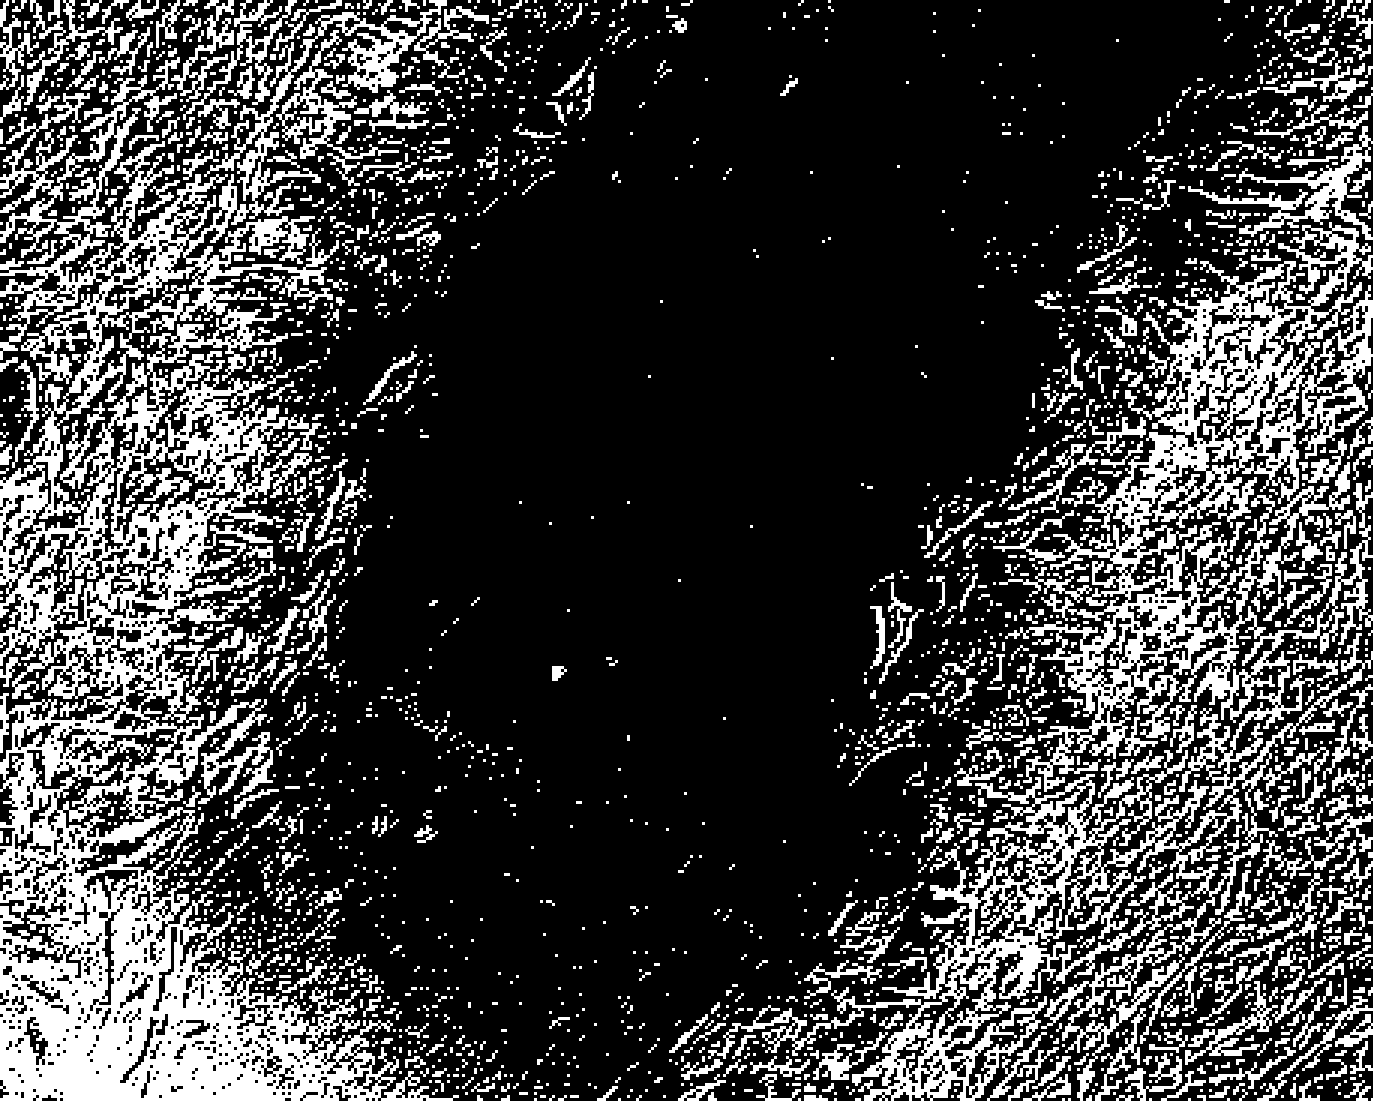

33.213573804123115


In [0]:
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
t = conf(gray,5)
cv2_imshow(t)
print(getpercent(t))